# 信号处理CFAR仿真

In [25]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import librosa as lb
import arlpy.uwapm as pm
import arlpy.plot as aplt
# add/change bathy to env
import os
os.environ["PATH"] += ":/Users/zanesing/Documents/at/Bellhop"
print(pm.models())
print(lb.__version__)

['bellhop']
0.10.2.post1


In [26]:
#TODO SSP
# add/change SSP to env
ssp = [                                 #Munk 声速刨面
  [  0.0 , 1548.52],[200.0 , 1530.29],[400.0 , 1517.78],[600.0 , 1509.49 ],  
  [800.0 , 1504.30],[1000.0 , 1501.38],[1200.0 ,1500.14],[1400.0 ,  1500.12],  
  [1600.0 ,1501.02],[1800.0 , 1502.57] , [2000.0 , 1504.62],[2200.0 , 1507.02 ],  
  [2400.0 , 1509.69 ],[2600.0 , 1512.55],[2800.0 , 1515.56],[3000.0 , 1518.67 ],
  [ 3200.0 , 1521.85 ],[3400.0 , 1525.10 ],[3600.0 , 1528.38],[3800.0 , 1531.70],
  [4000.0 , 1535.04],[4200.0 , 1538.39],[4400.0 , 1541.76 ],[4600.0 , 1545.14],
  [4800.0 , 1548.52 ],[5000.0 , 1551.91]
]

# Appending ssp and bathy to existing env file
env = pm.create_env2d(
    depth=5000,
    soundspeed=ssp,
    bottom_soundspeed=1551.91,
    bottom_density=1200,
    bottom_absorption=1.0,
    nbeams=70,
    tx_depth=200,
    rx_depth=400,
    frequency=1500,
    rx_range=500000
)
pm.print_env(env)


                name : arlpy
   bottom_absorption : 1.0
      bottom_density : 1200
    bottom_roughness : 0
   bottom_soundspeed : 1551.91
               depth : 5000
        depth_interp : linear
           frequency : 1500
           max_angle : 80
           min_angle : -80
              nbeams : 70
            rx_depth : 400
            rx_range : 500000
          soundspeed : [[   0.   1548.52]
                        [ 200.   1530.29]
                        [ 400.   1517.78]
                        [ 600.   1509.49]
                        [ 800.   1504.3 ]
                        [1000.   1501.38]
                        [1200.   1500.14]
                        [1400.   1500.12]
                        [1600.   1501.02]
                        [1800.   1502.57]
                        [2000.   1504.62]
                        [2200.   1507.02]
                        [2400.   1509.69]
                        [2600.   1512.55]
                        [2800.   1515.56]
        

In [27]:
pm.plot_env(env, width=800)

In [28]:
rays = pm.compute_rays(env , debug=False)
pm.plot_rays(rays, env=env,width=900)

第一会聚区在60km处

In [44]:
env['rx_range']=60000   #设置为60km
arrivals = pm.compute_arrivals(env)
pm.plot_arrivals(arrivals, width=900)
arrivals[arrivals.arrival_number < 10][['time_of_arrival', 'angle_of_arrival', 'surface_bounces', 'bottom_bounces']]

,time_of_arrival,angle_of_arrival,surface_bounces,bottom_bounces
1,41.708790,21.636990,3,2
2,41.551476,-18.381159,2,2
3,39.980862,15.387631,2,1
4,39.905022,-13.932588,0,0
5,39.891445,-10.020968,0,0
6,39.881451,-7.421494,0,0
7,39.963970,14.300425,1,1
8,41.424194,-16.942059,1,2
9,41.628117,16.037796,2,2
10,41.642586,21.056217,2,2


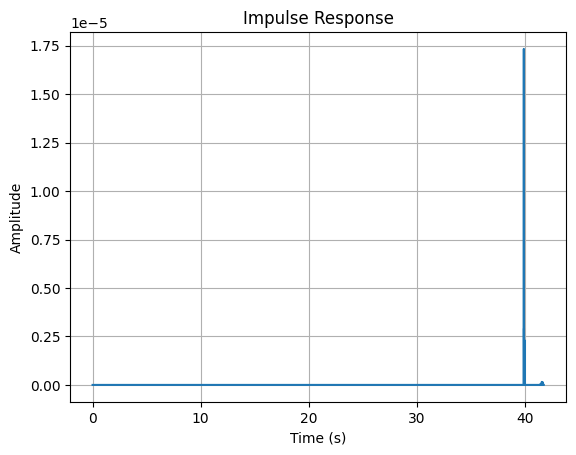

In [ ]:
fs = 4000
env['rx_range']=60000   #set target to 60km 
arrivals = pm.compute_arrivals(env)
ir = pm.arrivals_to_impulse_response(arrivals, fs=fs,abs_time=True)

aplt.plot(np.abs(ir), fs=4000, width=800) #有错误

"""Plot the impulse response."""
t = np.arange(len(ir)) / fs
plt.figure()
plt.plot(t, np.abs(ir))
plt.xlabel('Time (s)');plt.ylabel('Amplitude');plt.title('Impulse Response')
plt.grid(True);plt.show()


## 生成信号

信号形式:FMCW信号

In [49]:
from scipy.signal import chirp

# 生成单个金字塔Chirp的函数
def generate_pyramid_chirp(duration, f0, f1, fs):
    """生成单个对称金字塔形Chirp信号"""
    t = np.linspace(0, duration, int(duration * fs), endpoint=False)
    t_mid = duration / 2
    
    # 上升段
    up_segment = chirp(t[t <= t_mid], f0=f0, f1=f1, t1=t_mid, method='linear')
    # 下降段
    down_segment = chirp(t[t > t_mid] - t_mid, f0=f1, f1=f0, t1=t_mid, method='linear')
    
    return np.concatenate([up_segment, down_segment])

# 参数配置
fs = 4000           # 采样率
duration = 0.5      # 单个Chirp持续时间
f0, f1 = 1400, 1600 # 频率范围

# 生成基础Chirp（优化：预先生成避免重复计算）
base_chirp = generate_pyramid_chirp(duration, f0, f1, fs)


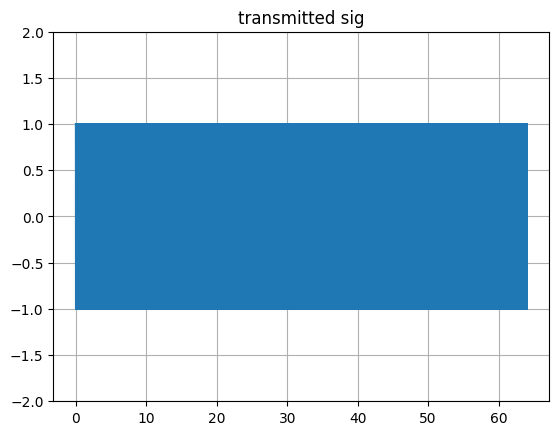

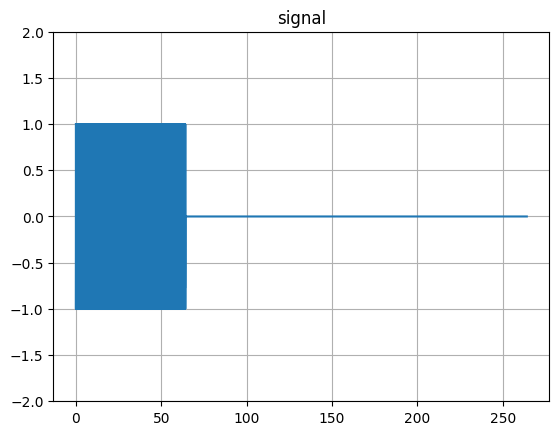

In [50]:
num_chirp = 128      # 重复次数
#高效拼接多个Chirp（避免使用循环内concatenate）
Tx = np.tile(base_chirp, num_chirp)  # 使用np.tile代替循环

t = np.linspace(0, num_chirp*duration, int(num_chirp*duration * fs), endpoint=False)

plt.figure
plt.title('transmitted sig')
plt.plot(t,Tx)
plt.grid(True);plt.ylim(-2,2);plt.show()

Tx_paddle = np.concatenate([Tx,np.zeros(int(200*fs))])

t = np.linspace(0, 200+128*duration, len(Tx_paddle), endpoint=False)
plt.figure
plt.title('signal')
plt.plot(t,Tx_paddle)
plt.grid(True);plt.ylim(-2,2);plt.show()


### 两次卷积计算回波

/opt/anaconda3/envs/sig_processing/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/sig_processing/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


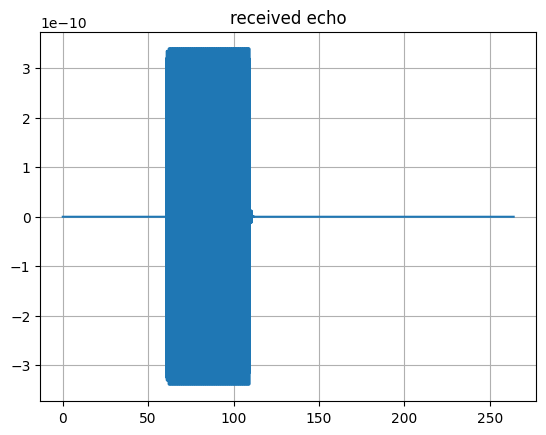

In [51]:
from scipy.signal import convolve

t = np.linspace(0, duration, int(duration * fs), endpoint=False)

# 第一次卷积：发射信号与信道1的脉冲响应卷积
s = convolve(Tx_paddle, ir, mode='full')
Rx=convolve(s, ir, mode='full')

t = np.linspace(0,200+128*duration, len(Rx))

plt.figure
plt.title('received echo')
plt.plot(t,Rx)
plt.grid(True)
plt.show()

### 1D-CFAR

In [10]:

# ============== 1D CA-CFAR 示例 ==============
def ca_cfar_1d(signal, guard_cells=2, train_cells=4, alpha=5):
    """
    简易1D CA-CFAR实现:
    - signal: 输入1D数据
    - guard_cells: 保护单元数(单侧)
    - train_cells: 训练单元数(单侧)
    - alpha: 阈值放大系数(简化)
    返回: cfar_mask(0/1), 表示该点是否被判定为目标
    """
    N = len(signal)
    cfar_mask = np.zeros(N, dtype=int)
    # 滑窗边界
    total_window = guard_cells + train_cells
    
    for i in range(total_window, N - total_window):
        # 训练区提取 (不包含保护单元和测试单元)
        start = i - total_window
        end = i + total_window + 1
        
        # 左侧训练区: [start, i - guard_cells)
        # 右侧训练区: (i + guard_cells, end)
        left_train = signal[start : i - guard_cells]
        right_train = signal[i + guard_cells + 1 : end]
        
        train_zone = np.concatenate((left_train, right_train))
        noise_est = np.mean(train_zone)  # CA: 取平均
        
        threshold = alpha * noise_est
        if signal[i] > threshold:
            cfar_mask[i] = 1
    
    return cfar_mask


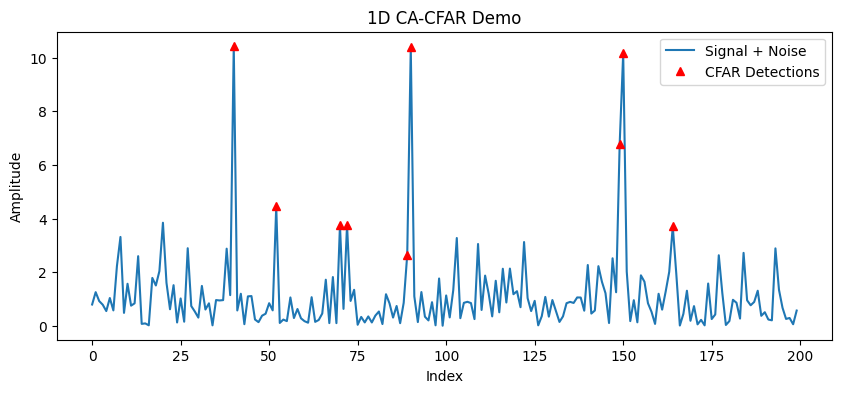

In [11]:
# ====== 测试1D CA-CFAR ======
np.random.seed(0)
N = 200
noise = np.random.exponential(scale=1, size=N)  # 指数分布噪声（常见非相干检测）
signal_1d = noise.copy()
# 人为加几个目标峰值
targets_pos = [40, 90, 150]
for pos in targets_pos:
    signal_1d[pos] += 10  # 增加较大的回波
    
# 应用1D CA-CFAR
cfar_mask_1d = ca_cfar_1d(signal_1d, guard_cells=2, train_cells=5, alpha=4)
detected_indices_1d = np.where(cfar_mask_1d==1)[0]

# 可视化1D结果
plt.figure(figsize=(10,4))
plt.plot(signal_1d, label='Signal + Noise')
plt.plot(detected_indices_1d, signal_1d[detected_indices_1d], 'r^', label='CFAR Detections')
plt.title('1D CA-CFAR Demo')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


### 2D-CFAR

In [12]:
# ============== 2D CA-CFAR 示例 ==============
def ca_cfar_2d(matrix, guard_cells=1, train_cells=2, alpha=5):
    """
    简易2D CA-CFAR (在距离-多普勒平面)
    - matrix: 输入2D矩阵 (距离 x 多普勒)
    - guard_cells: 每个方向上的保护单元大小
    - train_cells: 每个方向上的训练单元大小
    - alpha: 阈值放大系数(简化)
    返回: cfar_mask(同样大小的2D array), 1表示检测到目标, 0表示噪声
    """
    nr, nd = matrix.shape
    cfar_mask = np.zeros((nr, nd), dtype=int)
    
    # 逐个单元滑窗处理
    for r in range(train_cells+guard_cells, nr - train_cells - guard_cells):
        for d in range(train_cells+guard_cells, nd - train_cells - guard_cells):
            
            # 取训练区
            r_start = r - train_cells - guard_cells
            r_end   = r + train_cells + guard_cells + 1
            d_start = d - train_cells - guard_cells
            d_end   = d + train_cells + guard_cells + 1
            
            # 提取滑窗
            window_data = matrix[r_start:r_end, d_start:d_end]
            
            # 去掉保护区
            guard_r_start = r - guard_cells
            guard_r_end   = r + guard_cells + 1
            guard_d_start = d - guard_cells
            guard_d_end   = d + guard_cells + 1
            # 将保护区内的值置为None或移除
            # 方案1：先flatten全部，再排除保护区对应index
            window_flat = window_data.flatten()
            
            # 计算保护区相对索引并移除
            guard_zone = matrix[guard_r_start:guard_r_end, guard_d_start:guard_d_end].flatten()
            
            # 构造一个去除保护区的list
            # (这只是简化做法, 也可更优雅地使用mask等)
            train_list = []
            idx = 0
            for val in window_flat:
                if val not in guard_zone:
                    train_list.append(val)
                else:
                    # 为了避免'val not in guard_zone'的重复匹配问题,
                    # 这里更好做法是先把保护区index找出来再排除,
                    # 本例仅演示思路, 不考虑重复数值带来的影响.
                    pass
            train_list = np.array(train_list)
            noise_est = np.mean(train_list) if len(train_list)>0 else 0
            
            threshold = alpha * noise_est
            if matrix[r, d] > threshold:
                cfar_mask[r, d] = 1
    
    return cfar_mask
     

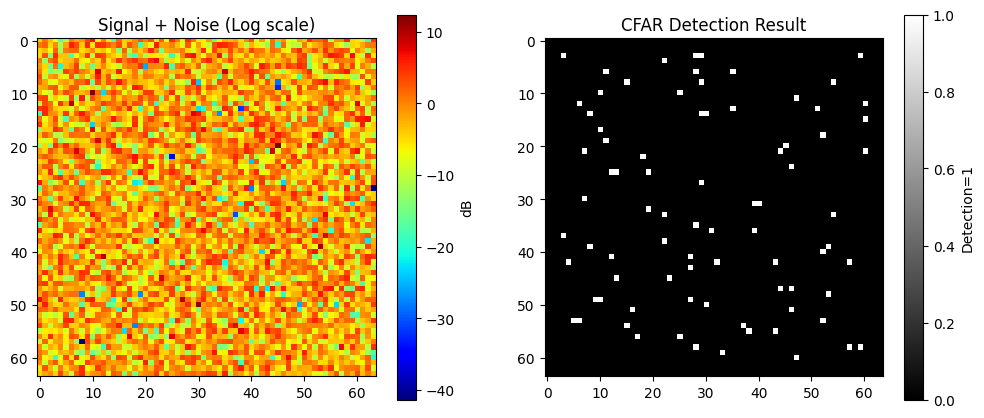

In [13]:
# ====== 测试2D CA-CFAR ======
# 模拟一个距离 x 多普勒的噪声背景
nr, nd = 64, 64
noise_2d = np.random.exponential(scale=1, size=(nr, nd))
signal_2d = noise_2d.copy()

# 人为加几个目标点
targets_2d = [(10, 10), (20, 45), (50, 30)]
for (rr, dd) in targets_2d:
    signal_2d[rr, dd] += 15  # 增加明显的回波
    
# 应用2D CA-CFAR
cfar_mask_2d = ca_cfar_2d(signal_2d, guard_cells=1, train_cells=2, alpha=4)
det_r, det_d = np.where(cfar_mask_2d==1)

# 可视化2D结果
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Signal + Noise (Log scale)')
plt.imshow(10*np.log10(signal_2d+1e-6), cmap='jet')
plt.colorbar(label='dB')
plt.subplot(1,2,2)
plt.title('CFAR Detection Result')
plt.imshow(cfar_mask_2d, cmap='gray')
plt.colorbar(label='Detection=1')
plt.show()
